# Space time worm

In [1]:
import os
from pathlib import Path
import json
import geojson
import requests
import math

#import netCDF4 as nc
import xarray as xr
import numpy as np
import pandas as pd
from geojson import Feature, Point, FeatureCollection, MultiPolygon, Polygon, load as geojson_load
from matplotlib import pyplot as plt
import folium

In [2]:
# Variables

# Distance/width of the corridor (total width/total height of bbox = 2*distance)
DIST_CORRIDOR = 30
# Ocean/Weather variables
GFS_VAR_LIST = ['u-component_of_wind_maximum_wind', 'v-component_of_wind_maximum_wind', 'Temperature_surface']
WAVE_VAR_LIST = ['VHM0','VPED','VTPK']
PHYS_VAR_LIST =['so','uo','vo']

# project directory
PROJECT_DIR = '/home/martin/Projekte/MariData/software/space_time_worm/'

# geojson file
ROUTE_FROM_GEOJSON = True
GEOJSON_FILE = 'space_time_worm_{}km.geojson'.format(DIST_CORRIDOR)
# needed if ROUTE_FROM_GEOJSON == False
SCRUBBER_FILE = '/home/martin/Projekte/MariData/data/Buettner/CB_scrubber_parsed.csv'

# netcdf files
DOWNLOAD = False
NC_SRC_DIR = '{}source_data/17_12_2021_30km'.format(PROJECT_DIR)
#NC_SRC_DIR = '{}source_data/20_01_2022_60km'.format(PROJECT_DIR)
#NC_SRC_DIR = '{}source_data/21_01_2022_45km'.format(PROJECT_DIR)
NC_FILE_REL_COORDS = '{}cmems_cube_{}km_relative_coordinates.nc'.format(PROJECT_DIR, DIST_CORRIDOR)
NC_FILE_GROUPS = '{}cmems_cube_{}km_groups.nc'.format(PROJECT_DIR, DIST_CORRIDOR)
NC_FILE_GROUPS_NO_ATTRS = NC_FILE_GROUPS.replace('.nc', '_no_attrs.nc')
NC_FILE_FULL_EXTENT = '{}source_data/full_extent.nc'.format(PROJECT_DIR)

---

## 1 ) Helper functions

In [3]:
# earth radius in km
r = 6371 

# distance between two meridians (1 deg longitude) in km at given latitude
def dist_meridian_km(lat):
    u = 2*np.pi*r
    return np.cos(np.deg2rad(lat)) * u / 360

def dist_lon_deg(d_km, lat):
    return d_km / dist_meridian_km(lat)

def dist_lat_deg(d_km):
    return d_km * 360 / (2*np.pi*r)

def corridor_bbox(p, dist, lat):
    return [p[0]-dist_lon_deg(dist, lat), 
         p[1]-dist_lat_deg(dist),
         p[0]+dist_lon_deg(dist, lat),
         p[1]+dist_lat_deg(dist)]

def bbox_to_polygon(bbox):
    return [[[bbox[0],bbox[1]],[bbox[2],bbox[1]],[bbox[2],bbox[3]],[bbox[0],bbox[3]],[bbox[0],bbox[1]]]]

def polygon_to_bbox(polygon):
    lons = [p[0] for p in polygon]
    lats = [p[1] for p in polygon]
    return [np.min(lons), np.min(lats), np.max(lons), np.max(lats)]

def walk_groups(top):
    yield top.groups.values()
    for value in top.groups.values():
        yield from walktree(value)

In [4]:
#date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M:%SZ')
date_to_str = lambda x: x.strftime('%Y-%m-%dT%H:%M')

def build_env_data_url(lon_lo, lon_hi, lat_lo, lat_hi, date_lo, date_hi, 
                       wave_params=WAVE_VAR_LIST, phys_params=PHYS_VAR_LIST,
                       gfs_params=GFS_VAR_LIST, format='netcdf'):
    base_url = 'https://harvester.maridata.dev.52north.org/EnvDataAPI/request_env_data?'
    url = base_url + 'date_lo={}'.format(date_to_str(date_lo))
    url = url + '&date_hi={}'.format(date_to_str(date_hi))
    url = url + '&lat_lo={}'.format(lat_lo)
    url = url + '&lat_hi={}'.format(lat_hi)
    url = url + '&lon_lo={}'.format(lon_lo)
    url = url + '&lon_hi={}'.format(lon_hi)
    for param in wave_params:
        url = url + '&Wave={}'.format(param)
    for param in phys_params:
        url = url + '&Physical={}'.format(param)
    for param in gfs_params:
        url = url + '&GFS={}'.format(param)
    url = url + '&format={}'.format(format)

    return url

In [5]:
def transform_coordinates(dataset, point):
    """Transform coordinates to relative grid starting at (0,0)"""
    round_precision = 6
    dataset = dataset.assign_coords(longitude=lambda dataset: np.round(dataset.longitude - point[0], round_precision))
    dataset = dataset.assign_coords(latitude=lambda dataset: np.round(dataset.latitude - point[1], round_precision))
    #print(dataset)
    return dataset

In [6]:
def save_with_groups(datasets, out, group_base='point'):
    """
    Save xarray datasets to netCDF file adding every dataset as separate group
    :param datasets: list of xarray datasets
    :out: str
        name of output file (absolute path)
    :group_base: str
        base name of the group (number is appended automatically)
    :returns: filename of created file
    """
    if Path(out).exists():
        try:
            os.remove(out)
            print('Removed file {}'.format(out))
        except OSError:
            pass
    
    for idx, dataset in enumerate(datasets):
        if idx == 0:
            dataset.to_netcdf(out, 'w', group='/{}_{:02d}'.format(group_base, idx+1))
        else:
            dataset.to_netcdf(out, 'a', group='/{}_{:02d}'.format(group_base, idx+1))
    
    return out

def save_with_local_grid(datasets, out):
    pass

---

## 2) Create route and bboxes

### 2.1) Define route 

<ol>
  <li>Read example scrubber trajectory data</li>
  <li>Define time series for 2 days with a 3-hour interval</li>
  <li>Extract coordinates for time series from step 2</li>
  <li>Create geojson with time series and coordinates</li>
</ol>

In [7]:
if not ROUTE_FROM_GEOJSON:
    df = pd.read_csv(SCRUBBER_FILE)

In [8]:
if not ROUTE_FROM_GEOJSON:
    times = pd.date_range("2021-04-02 00:00:00", periods=16, freq="3H")
    print(times)

In [9]:
if not ROUTE_FROM_GEOJSON:
    time_filter = [False] * len(df)
    for time in times:
        time_filter = time_filter | (df['Date/Time (UTC)'] >= str(time+pd.Timedelta(-2,'m'))) & (df['Date/Time (UTC)'] <= str(time+pd.Timedelta(2,'m')))

    df_filtered = df[time_filter]
    print(len(df_filtered))

In [10]:
if not ROUTE_FROM_GEOJSON:
    points = list(zip(round(df_filtered['Longitude'], 1),round(df_filtered['Latitude'], 1)))
    print(points)

In [11]:
if not ROUTE_FROM_GEOJSON:
    point_features = []

    for idx, point in enumerate(points):
        point_features.append(Feature(geometry=Point(point), properties={"time": str(times[idx])}))

    route_geojson = FeatureCollection(point_features)
    print(json.dumps(route_geojson, indent=2))

### 2.2) Define bboxes

<ol>
  <li>Convert distance in km to distance in degree</li>
  <li>Create bbox for every point on route (point + distance in degree in each direction (N, W, S, E))</li>
</ol>

In [12]:
# Use maximum latitude as it will produce the largest bbox
if not ROUTE_FROM_GEOJSON:
    lat_max = np.max([p[1] for p in points])
    print('Maximum latitude:', lat_max)

In [13]:
if not ROUTE_FROM_GEOJSON:
    bboxes = []
    polygon_features = []
    for idx, p in enumerate(points):
        bbox = corridor_bbox(p, DIST_CORRIDOR, lat_max)
        bboxes.append(bbox)
        polygon = bbox_to_polygon(bbox)
        polygon_features.append(Feature(geometry=Polygon(polygon), properties={"time": str(times[idx])}))
        print("[{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}]".format(*bbox))
    
    polygon_geojson = FeatureCollection(polygon_features)
    print(json.dumps(polygon_geojson, indent=2))

### 2.3) Save geojson with route and bboxes

In [14]:
if not ROUTE_FROM_GEOJSON:
    route_bboxes_geojson = FeatureCollection(point_features + polygon_features)
    with open(GEOJSON_FILE, 'w') as outfile:
        geojson.dump(route_bboxes_geojson, outfile, indent=2)
    print(json.dumps(route_bboxes_geojson, indent=2))

---

## 3) Read route and bboxes from geojson 

In [15]:
if ROUTE_FROM_GEOJSON:
    with open(GEOJSON_FILE) as f:
        route_bboxes_geojson = geojson_load(f)
    times = pd.date_range(route_bboxes_geojson['features'][0]['properties']['time'],route_bboxes_geojson['features'][-1]['properties']['time'], freq="3H")
    points = [tuple(p['geometry']['coordinates']) for p in route_bboxes_geojson['features'] if p['geometry']['type']=='Point']
    polygons = [p['geometry']['coordinates'] for p in route_bboxes_geojson['features'] if p['geometry']['type']=='Polygon']
    bboxes = []
    for polygon in polygons:
        bbox = polygon_to_bbox(polygon[0])
        bboxes.append(bbox)

---

## 4) Visualize route and bboxes 

In [16]:
route_map = folium.Map( location=[49.0, -1.5], zoom_start=6 )
for idx in range(0, len(route_bboxes_geojson['features'])):
    folium.GeoJson(data=route_bboxes_geojson['features'][idx]['geometry']).add_to(route_map) \
    .add_child(folium.Popup(route_bboxes_geojson['features'][idx]['properties']['time'])).add_to(route_map)
route_map

---

## 5) Get environmental data along route 

### 5.1) Download data

Download data using the Environmental Data API: https://harvester.maridata.dev.52north.org/EnvDataAPI/

Documentation: https://github.com/52North/MariDataHarvest/tree/main/EnvDataServer

In [17]:
if DOWNLOAD:
    data_links = []
    headers = {'Accept': 'application/json'}
    
    for j in range(0, len(bboxes)):
        if len(bboxes) != len(times):
            break
        lon_lo = bboxes[j][0]
        lon_hi = bboxes[j][2]
        lat_lo = bboxes[j][1]
        lat_hi = bboxes[j][3]
        date_lo = times[j]
        date_hi = times[j]
        
        url = build_env_data_url(lon_lo, lon_hi, lat_lo, lat_hi, date_lo, date_hi)
        print('Requesting: {}'.format(url))
        resp = requests.get(url, headers=headers)
        if resp.status_code == 200:
            resp_data = resp.json()
            data_links.append(resp_data['link'])
            print('Response: {}'.format(resp_data))
        else:
            print('Response: {}'.format(resp.status_code))

### 5.2) Load from files

In [18]:
file_names = []

for file in os.listdir(NC_SRC_DIR):
    file_names.append(os.path.join(NC_SRC_DIR, file))

datasets = []
for file_name in file_names:
    datasets.append(xr.load_dataset(file_name))

In [19]:
# Sort by time
datasets.sort(key=lambda l: l.time[0])

# Drop time slice (env data api always returns time ranges not single time steps)
for idx, dataset in enumerate(datasets):
    datasets[idx] = dataset.drop_isel(time=0)
    #print(list(dataset.data_vars))

In [20]:
# Add non-existing variables as NaNs to datasets because it will cause problems during concatenation, see
# https://github.com/pydata/xarray/issues/508
dataset_vars = set()    
for dataset in datasets:
    dataset_vars.update(list(dataset.data_vars))

for idx, dataset in enumerate(datasets):
    print('Dataset {} of {}'.format(idx+1, len(datasets)))
    for dataset_var in dataset_vars:
        if dataset_var not in list(dataset.data_vars):
            print('   Variable "{}" not in dataset. Adding variable with NaNs.'.format(dataset_var))
            dataset[dataset_var] = xr.full_like(dataset[list(dataset.data_vars)[0]], np.nan)     

Dataset 1 of 16
Dataset 2 of 16
Dataset 3 of 16
Dataset 4 of 16
Dataset 5 of 16
Dataset 6 of 16
Dataset 7 of 16
Dataset 8 of 16
Dataset 9 of 16
Dataset 10 of 16
Dataset 11 of 16
Dataset 12 of 16
Dataset 13 of 16
Dataset 14 of 16
   Variable "v-component_of_wind_maximum_wind" not in dataset. Adding variable with NaNs.
   Variable "u-component_of_wind_maximum_wind" not in dataset. Adding variable with NaNs.
   Variable "Temperature_surface" not in dataset. Adding variable with NaNs.
Dataset 15 of 16
Dataset 16 of 16


---

## 6) Visualize environmental data

In [21]:
# For debug
#ds_times = []
#for dataset in datasets:
#    ds_times.append(dataset.time.values)
#    print(dataset.time.values)
#ds_times = [item for sublist in ds_times for item in sublist]

In [22]:
# For debug
#ds_times.sort()
#ds_times

In [23]:
# For debug
#times.strftime("%Y-%m-%d %H:%M:%S").tolist().index('2021-04-02 09:00:00')
#times.strftime("%Y-%m-%d %H:%M:%S").tolist().index('2021-04-02 12:00:00')

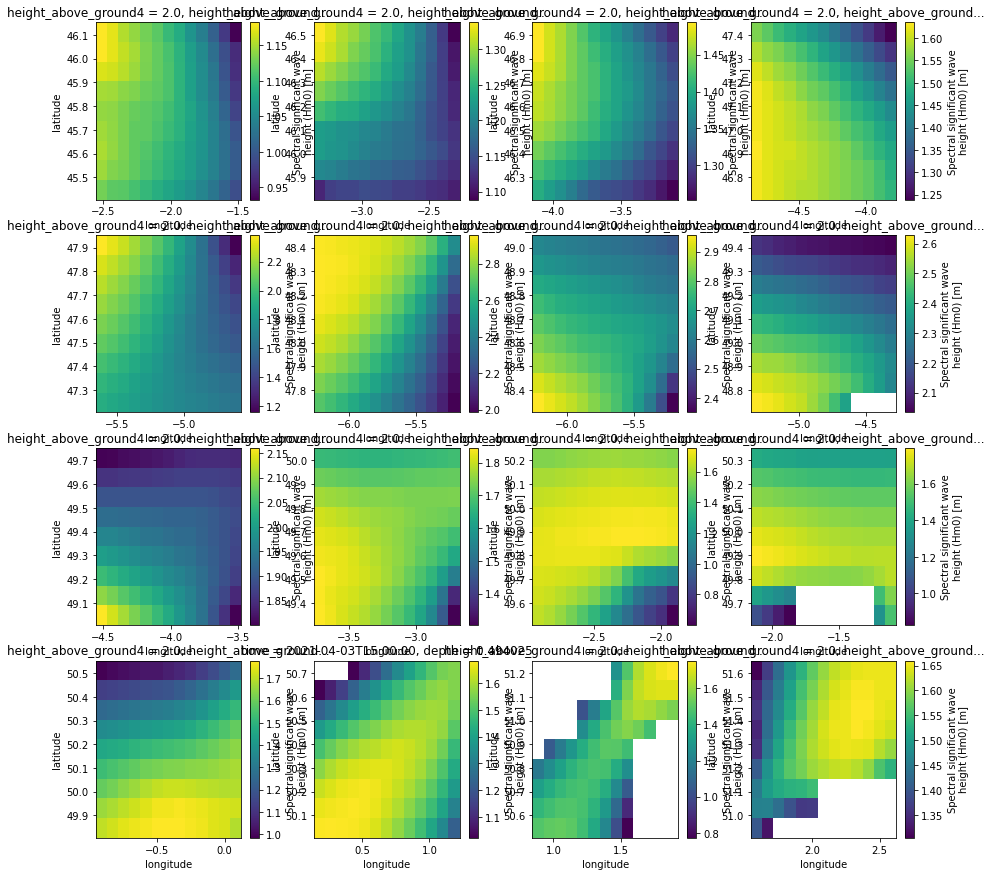

In [24]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,15))

col = 0
row = 0
for idx, dataset in enumerate(datasets):
    idx = idx + 1
    #print(idx, row, col)
    dataset.isel(time=0).VHM0.plot(ax=axes[row, col])
    #dataset.isel(time=0).VHM0.plot(ax=axes[row, col], vmin=1.2, vmax=2.7)
    if idx % 4 == 0:
        row = row + 1
        col = 0
    else:
        col = col + 1

---

## 7) Space time worm with netCDF groups

xarray does not support a data structure with multiple groups. A Dataset corrsponds to a single group in a netCDF file.
http://xarray.pydata.org/en/stable/user-guide/io.html#groups

### 7.1) Save data

In [25]:
#save_with_groups(datasets, NC_FILE_GROUPS)

In [26]:
# Remove attributes before saving
datasets_no_attrs = []
attrs = None
for idx in range(1,len(datasets)):
    dataset_copy = datasets[idx].copy()
    # Remove global attributes
    dataset_copy.attrs.clear()
    # Remove variable attributes
    for varname, array in dataset_copy.data_vars.items():
        array.attrs.clear()
    # Remove coordinate attributes
    for coordname, array in dataset_copy.coords.items():
        array.attrs.clear()
    datasets_no_attrs.append(dataset_copy)
    
#save_with_groups(datasets_no_attrs, NC_FILE_GROUPS_NO_ATTRS)

### 7.2) Load data

In [27]:
datasets_group = []
for idx in range(1,17):
    datasets_group.append(xr.load_dataset(NC_FILE_GROUPS, group='point_{:02d}'.format(idx)))
#datasets_group

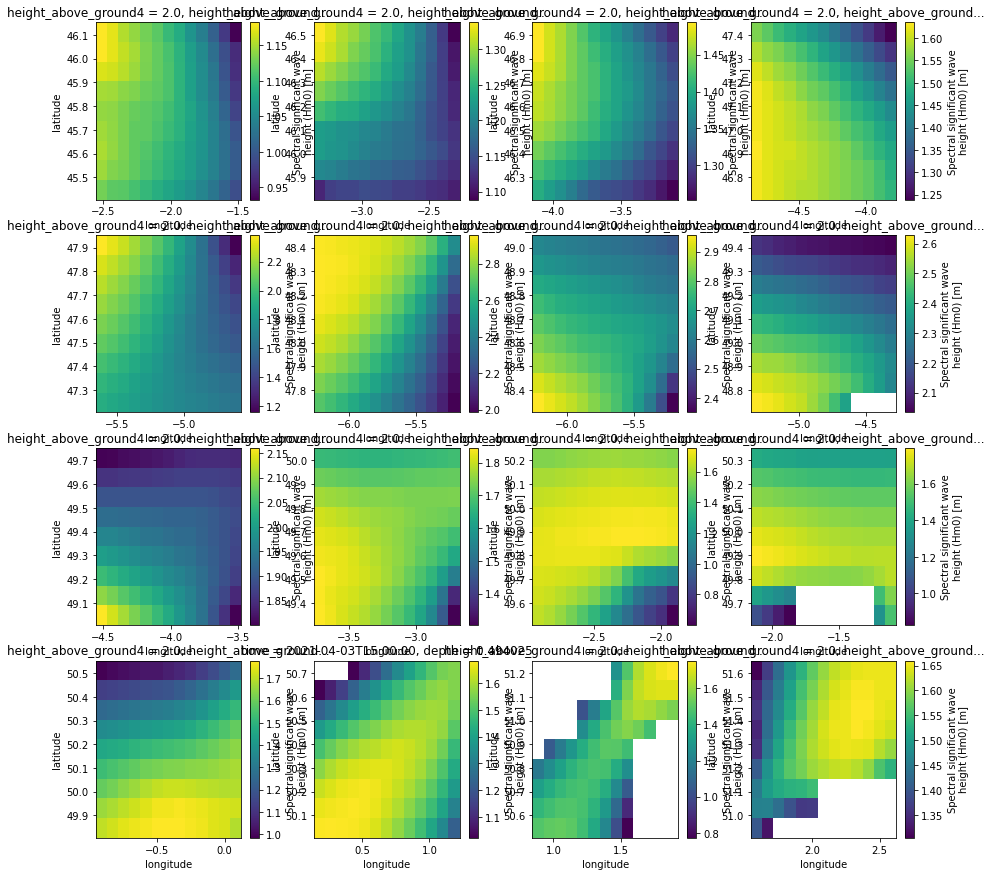

In [28]:
fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(15,15))

col = 0
row = 0
for idx, dataset in enumerate(datasets_group):
    idx = idx + 1
    #print(idx, row, col)
    dataset.isel(time=0).VHM0.plot(ax=axes[row, col])
    #dataset.isel(time=0).VHM0.plot(ax=axes[row, col], vmin=1.2, vmax=2.7)
    if idx % 4 == 0:
        row = row + 1
        col = 0
    else:
        col = col + 1

---

## 8) Space time worm with relative coordinates (single grid)

Challenges:
* How to make sure all relative grids are identical?

### 8.1) Save data

#### 8.1.1) Transform grids

In [29]:
datasets_rel_coords = []
# Make sure order of datasets and points is correct
for idx, dataset in enumerate(datasets):
    datasets_rel_coords.append(transform_coordinates(dataset.copy(), points[idx]))
#datasets_rel_coords

In [30]:
# For debug
#for dataset in datasets_rel_coords:
    #print(dataset.longitude.values)
    #print(dataset.longitude.values.tolist()) # for full precision
    #print(dataset.latitude.values)
    #print(dataset.latitude.values.tolist()) # for full precision
    #print(dataset.time.values)
    #print(list(dataset.data_vars))

#### 8.1.2) Combine datasets

In [31]:
combined = xr.concat(datasets_rel_coords, dim='time', coords='minimal')
# "(attribute) must be a number, a string, an ndarray or a list/tuple of numbers/strings for serialization to netCDF files"
#combined.attrs['grid_shift'] = dict(zip(combined.time.values.astype(str).tolist(), points))
combined = combined.assign_coords(route_lon=[point[0] for point in points])
combined = combined.assign_coords(route_lat=[point[1] for point in points])
combined

<xarray.Dataset>
Dimensions:                           (latitude: 9, longitude: 13, route_lat: 16, route_lon: 16, time: 16)
Coordinates:
    height_above_ground4              float64 2.0
    height_above_ground_layer1        float64 3e+03
  * latitude                          (latitude) float64 -0.3528 ... 0.3112
  * longitude                         (longitude) float64 -0.5145 ... 0.4815
  * time                              (time) datetime64[ns] 2021-04-02 ... 20...
    depth                             float32 0.494
  * route_lon                         (route_lon) float64 -2.0 -2.8 ... 1.4 2.1
  * route_lat                         (route_lat) float64 45.8 46.2 ... 51.3
Data variables:
    VHM0                              (time, latitude, longitude) float64 1.1...
    VPED                              (time, latitude, longitude) float64 277...
    VTPK                              (time, latitude, longitude) float64 11....
    so                                (time, latitude, longitude) float64 35....
    uo                                (time, latitude, longitude) float64 -0....
    vo                                (time, latitude, longitude) float64 0.0...
    u-component_of_wind_maximum_wind  (time, latitude, longitude) float64 -14...
    v-component_of_wind_maximum_wind  (time, latitude, longitude) float64 9.5...
    Temperature_surface               (time, latitude, longitude) float64 285...
Attributes:
    timeRange:     Time range: 2021-04-01 21:00:00 to 2021-04-02 03:00:00
    lon_extent:    Longitude extent: -2.51 to -1.49
    lat_extent:    Latitude extent: 45.45 to 46.15
    spatial_res:   Spatial Resolution 0.083deg x 0.083deg
    temporal_res:  Temporal Resolution 3-hours interval
    credit_CMEMS:  Credit (Wave-Wind-Physical): E.U. Copernicus Marine Servic...
    credit_GFS:    Credit (GFS): National Centers for Environmental Predictio...
    created:       Accessed on 2021-12-17 14:53:15
    errors:        Error(s):

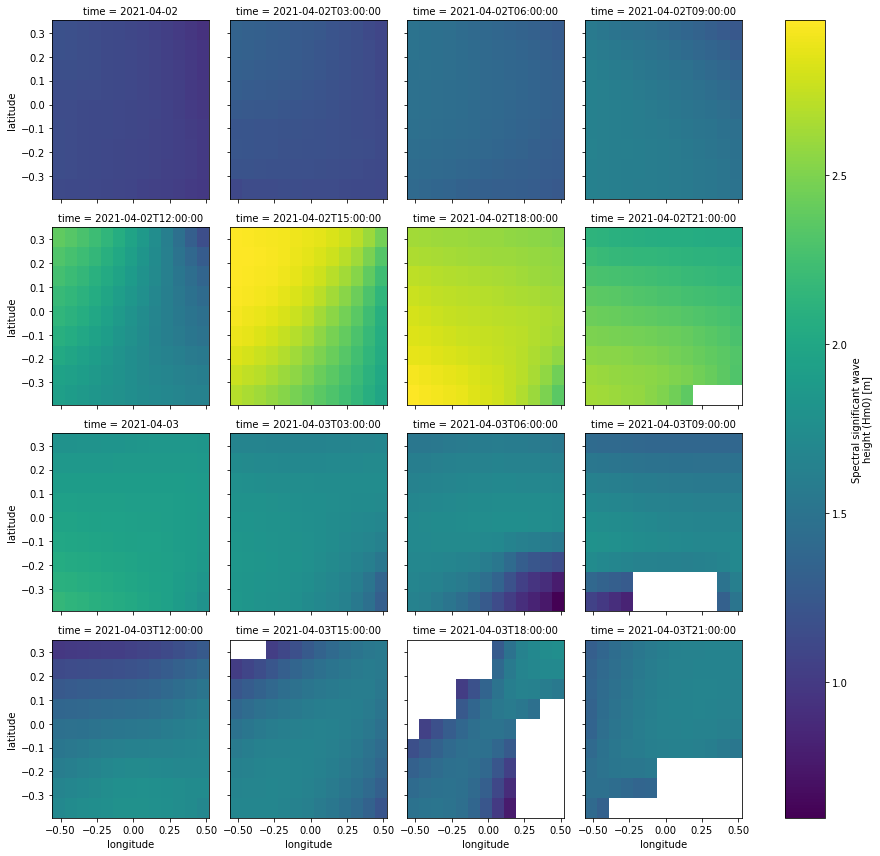

In [32]:
combined.VHM0.plot(x="longitude", y="latitude", col="time", col_wrap=4);

In [33]:
combined.to_netcdf(NC_FILE_REL_COORDS)

### 8.2) Load data 

---

## 9) Full extent (time and space)

In [34]:
datasets_full = xr.load_dataset(NC_FILE_FULL_EXTENT)
#datasets_full

---

## 10) Memory comparison

Attributes
<ol>
  <li>Global attributes</li>
  <li>Coordinate attributes</li>
  <li>Data variable attributes</li>
</ol>

In [35]:
memory_groups = os.stat(NC_FILE_GROUPS).st_size
memory_groups_no_attrs = os.stat(NC_FILE_GROUPS_NO_ATTRS).st_size
memory_rel_coords = os.stat(NC_FILE_REL_COORDS).st_size
memory_full_extent = os.stat(NC_FILE_FULL_EXTENT).st_size
print('Full extent:', memory_full_extent / 1000, 'kB')
print('Group approach:', memory_groups / 1000, 'kB')
print('Group approach without attributes:', memory_groups_no_attrs / 1000, 'kB')
print('Relative coordinates approach:', memory_rel_coords / 1000, 'kB')
print('Factor (memory_groups/memory_rel_coords):', memory_groups / memory_rel_coords)
print('Factor (memory_groups_no_attrs/memory_rel_coords):', memory_groups_no_attrs / memory_rel_coords)

Full extent: 8160.776 kB
Group approach: 876.369 kB
Group approach without attributes: 405.74 kB
Relative coordinates approach: 187.52 kB
Factor (memory_groups/memory_rel_coords): 4.673469496587031
Factor (memory_groups_no_attrs/memory_rel_coords): 2.163715870307167


In [36]:
total_bbox = [np.min([p[0] for p in points]), 
              np.min([p[1] for p in points]),
              np.max([p[0] for p in points]),
              np.max([p[1] for p in points])]
total_bbox

[-5.7, 45.8, 2.1, 51.3]

In [37]:
resx = resy = 0.083 # in deg
memory_per_pixel = 8 # bytes (float64)
num_vars = 9 # number of variables

In [38]:
nx = math.ceil((total_bbox[2]-total_bbox[0])/resx)
ny = math.ceil((total_bbox[3]-total_bbox[1])/resy)
print("nx = {}, ny = {}".format(nx, ny))

nx = 94, ny = 67


In [39]:
# Estimate memory for full extent
memory_total = nx * ny * len(times) * num_vars * memory_per_pixel + \
               (nx + ny  + len(times)) * memory_per_pixel
print('Memory for total bbox:', memory_total / 1000, 'kB')

Memory for total bbox: 7256.712 kB
